# LangGraph를 사용한 고객 지원 챗봇을 구축

- 웹 검색을 통해 일반적인 질문에 답변 
- 대화 상태를 유지하여 연속적인 대화  
- 복잡한 질문을 사람이 검토하도록 라우팅  
- 사용자 지정 상태(Custom State)를 활용하여 챗봇의 동작 제어  
- 대화 흐름을 되돌리고(Rewind), 다른 대화 경로 탐색 

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# LangSmith 추적 설정 활성화
os.environ["LANGSMITH_TRACING"] = "true"

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

먼저 모델을 직접 사용해 봅니다. `ChatModel`은 LangChain의 **"Runnable"** 인스턴스이며, 이는 표준화된 인터페이스를 통해 상호작용할 수 있음을 의미합니다.  

모델을 간단하게 호출하려면 `.invoke` 메서드에 **메시지 목록**을 전달하면 됩니다.

In [4]:
from langchain_core.messages import HumanMessage

response = llm.invoke([HumanMessage(content="안녕! 나는 길동이야.")])
response.content

'안녕, 길동이! 만나서 반가워. 어떻게 도와줄까?'

모델 자체는 **상태(state)** 라는 개념을 가지고 있지 않습니다. 예를 들어, 후속 질문을 하면:

In [5]:
response = llm.invoke([HumanMessage(content="내 이름이 뭐라고 했지?")])
response.content

'죄송하지만, 제가 이전 대화 내용을 기억하지 않아서 당신의 이름을 알지 못해요. 이름을 다시 알려주시면 도와드릴 수 있어요!'

In [6]:
from langchain_core.messages import AIMessage

response = llm.invoke(
    [
        HumanMessage(content="안녕! 나는 길동이야."),
        AIMessage(content="안녕하세요, 길동님. 무엇을 도와 드릴까요?"),
        HumanMessage(content="내 이름이 뭐라고 했지?"),
    ]
)

response.content

'당신의 이름이 길동이라고 하셨어요.'

<br>
이제 좋은 응답을 받는 것을 확인할 수 있습니다!  

이것이 챗봇이 **대화형 상호작용**을 할 수 있는 기본 아이디어입니다.  

## 챗봇에 메모리 기능 추가¶

현재 챗봇은 **사용자 질문에 도구를 활용해 답변할 수 있지만, 이전 대화의 맥락을 기억하지 못합니다.**  
이 때문에 **일관된 멀티턴(Multi-turn) 대화를 진행하는 데 한계가 있습니다.**  

LangGraph는 **"지속적 체크포인트(Persistent Checkpointing)"** 기능을 통해 이 문제를 해결합니다.  

그래프를 컴파일할 때 checkpointing을 활성화하고 그래프를 호출할 때 `thread_id`를 제공하면, LangGraph가 자동으로 상태(state)를 저장하고, 다음 실행 시 이전 상태를 복원합니다.  

즉, **동일한 `thread_id`** 를 사용하여 그래프를 호출하면, 이전 대화 상태를 불러와서 이어서 대화할 수 있습니다!

In [7]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

우리는 현재 **메모리를 활용하는(in-memory) 체크포인터**를 사용하고 있습니다.  

이 방식은 튜토리얼 환경에서는 편리하지만, 데이터가 메모리에만 저장되므로 영구적이지 않습니다. 실제 프로덕션 환경에서는 `SqliteSaver` 또는 `PostgresSaver`를 사용하여 데이터베이스(DB)와 연결하는 것이 일반적입니다.

---

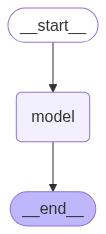

In [8]:
from langgraph.graph import START, MessagesState, StateGraph

# 새로운 그래프 정의
workflow = StateGraph(state_schema=MessagesState)

# 모델을 호출하는 함수 정의
def call_model(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": response}

# 그래프의 (단일) 노드 정의
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# 메모리 추가
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

이제 챗봇과 상호작용할 수 있습니다. 먼저, 이 대화를 식별할 수 있는 **`thread`(스레드)** 를 선택합니다.

In [9]:
config = {"configurable": {"thread_id": "1"}}

user_input = [HumanMessage("안녕하세요! 제 이름은 길동이에요.")]

# config는 stream() 또는 invoke()의 두 번째 인자
output = app.invoke(
    {"messages": user_input},
    config,
)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요, 길동님! 만나서 반가워요. 어떻게 도와드릴까요?


이제 후속 질문(follow-up question)을 해봅시다. 챗봇이 사용자의 이름을 기억하는지 확인해 봅니다.

In [10]:
user_input = [HumanMessage("내 이름이 뭐야?")]

output = app.invoke(
    {"messages": user_input},
    config,
)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

길동님이시라고 하셨으니, 이름이 길동이신 것 같아요!


In [11]:
config = {"configurable": {"thread_id": "2"}}

user_input = [HumanMessage("내 이름이 뭐야?")]

output = app.invoke(
    {"messages": user_input},
    config,
)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

죄송해요, 제가 당신의 이름을 알지 못해요.


In [12]:
config = {"configurable": {"thread_id": "1"}}
user_input = [HumanMessage("내 이름이 뭐야?")]

output = app.invoke(
    {"messages": user_input},
    config,
)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

당신의 이름은 길동이라고 하셨어요! 맞나요?


### 프롬프트 템플릿(Prompt Templates)을 사용하여 LLM 호출 최적화

**프롬프트 템플릿** 은 **원시 사용자 입력(raw user input)** 을 LLM이 처리할 수 있는 형식으로 변환하는 데 도움을 줍니다.   

1. 먼저, **시스템 메시지(system message)** 를 추가하여 **사용자 정의 지침(custom instructions)** 을 포함시킵니다. (여전히 메시지를 입력으로 사용)  
2. 다음으로, 메시지 외에 **더 많은 입력 정보** 를 추가합니다.  

#### **시스템 메시지(System Message) 추가하기**

시스템 메시지를 추가하기 위해 **`ChatPromptTemplate`** 을 생성합니다. 여기서는 메시지 전달을 위해 **`MessagesPlaceholder`** 를 사용하겠습니다.  

이렇게 하면 LLM에 전달되는 입력이 더 구조화되고, 챗봇의 동작을 더 정교하게 제어할 수 있습니다.  

```
┌─────────────────────────────┐
│       LangGraph State       │
│  MessagesState = {"messages": [...] } │
└─────────────────────────────┘
             │
             ▼
 ┌────────────────────────────────────┐
 │ ChatPromptTemplate.from_messages  │
 │ ┌──────────────────────────────┐ │
 │ │ "system": "친구처럼 말해줘"     │ │
 │ │ MessagesPlaceholder("messages") │◄─── state["messages"]
 │ └──────────────────────────────┘ │
 └────────────────────────────────────┘
             │
             ▼
    llm.invoke(prompt) 수행
             │
             ▼
 ┌──────────────────────────────┐
 │   LLM 응답: AIMessage(...)   │
 └──────────────────────────────┘
             │
             ▼
 ┌──────────────────────────────┐
 │ return {"messages": response}│ ──► 다음 Graph Step 으로 상태 전달
 └──────────────────────────────┘
```

In [13]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# LLM이 사용자 입력을 더 잘 처리할 수 있도록 프롬프트 템플릿을 설정합니다.
prompt_template = ChatPromptTemplate.from_messages(
    [
        # LLM의 동작 방식을 정의하는 지침
        (
            "system",
            "당신은 친구 처럼 말합니다. 모든 질문에 최선을 다해 대답하세요.",
        ),

        # Messages Placeholder - 이전 대화 메시지들을 전달합
        MessagesPlaceholder(variable_name="messages"),
    ]
)

이제 이 템플릿을 통합하여 애플리케이션을 업데이트할 수 있습니다.

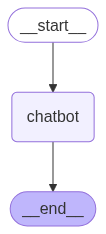

In [14]:
from langgraph.graph import START, MessagesState, StateGraph

# 상태 스키마(State)를 정의하여 그래프 생성기 초기화
workflow = StateGraph(state_schema=MessagesState)

# 모델 호출 함수 정의
def chatbot(state: MessagesState):
    # 현재 상태(state)에 포함된 메시지를 기반으로 프롬프트 생성
    prompt = prompt_template.invoke(state)
    
    # 생성된 프롬프트를 LLM에 전달하여 응답을 생성
    response = llm.invoke(prompt)
    
    # LLM 응답을 딕셔너리 형태로 반환 (다음 상태로 전달됨)
    return {"messages": response}

# chatbot 노드를 그래프에 추가
workflow.add_node("chatbot", chatbot)

# MemorySaver를 사용하여 대화 상태를 저장할 메모리 객체 생성
memory = MemorySaver()

# 그래프의 시작 지점(START)에서 chatbot 노드로 연결
workflow.add_edge(START, "chatbot")

# 모든 구성 요소를 종합하여 그래프를 컴파일 (메모리를 체크포인터로 사용)
graph = workflow.compile(checkpointer=memory)

# 컴파일된 그래프 객체를 확인
graph

In [15]:
# 'configurable' 키를 사용하여 추가적인 설정 값을 전달합니다.
# 여기서는 'thread_id'를 사용하여 특정 대화 스레드를 식별합니다.
config = {"configurable": {"thread_id": "abc345"}}

# 메시지 목록에 사용자 메시지 추가
input_messages = [HumanMessage("안녕. 나는 길동이야.")]

# 애플리케이션 호출
# 메시지 상태(State), 설정(config) 전달
output = graph.invoke({"messages": input_messages}, config)

output["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕 길동이! 반가워. 오늘 기분은 어때? 무엇이든 이야기하고 싶으면 편하게 말해줘!


In [16]:
# 'configurable' 키를 사용하여 추가적인 설정 값을 전달합니다.
# 여기서는 'thread_id'를 사용하여 특정 대화 스레드를 식별합니다.
config = {"configurable": {"thread_id": "abc345"}}

# 메시지 목록에 사용자 메시지 추가
input_messages = [HumanMessage("내 이름이 뭐지?")]

# 애플리케이션 호출
# 메시지 상태(State), 설정(config) 전달
output = graph.invoke({"messages": input_messages}, config)

output["messages"][-1].pretty_print()

================================== Ai Message ==================================

미안하지만, 너의 이름이 뭐였는지 기억이 안 나. 혹시 다시 알려줄래?


In [17]:
state_snapshot = graph.get_state(config={"configurable":{"thread_id": "abc345"}})
print(state_snapshot.values["messages"])  # 이전 메시지 리스트

[HumanMessage(content='안녕. 나는 길동이야.', additional_kwargs={}, response_metadata={}, id='49b3731c-d427-4a5d-9675-2ff2eb71dda6'), AIMessage(content='안녕 길동이! 반가워. 오늘 기분은 어때? 무엇이든 이야기하고 싶으면 편하게 말해줘!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 40, 'total_tokens': 70, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-Bq8cJum8UvbASBXnLwBD3S7mtsR0C', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f4513157-6e15-48a7-ad66-23ca06740e2b-0', usage_metadata={'input_tokens': 40, 'output_tokens': 30, 'total_tokens': 70, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='내 이

### 무한 loop 로 Chatbot 구현

In [18]:
# 'configurable' 키를 사용하여 추가적인 설정 값을 전달합니다.
# 여기서는 'thread_id'를 사용하여 특정 대화 스레드를 식별합니다.
memory = MemorySaver()

# 그래프를 메모리 체크포인트와 함께 컴파일합니다.
graph = workflow.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "abc345"}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    output = graph.invoke({"messages": user_input}, config)
    output["messages"][-1].pretty_print()

User:  안녕 난 길동이야


================================== Ai Message ==================================

안녕 길동이! 반가워. 오늘 기분은 어때? 뭐 하고 싶거나 궁금한 거 있으면 말해줘!


User:  랭그래프가 뭐야


================================== Ai Message ==================================

랭그래프는 어떤 데이터를 순위별로 보여주는 그래프야. 예를 들어, 인기 있는 영화, 선수, 노래 등을 인기순(순위)에 따라 표시하는 거지. 보통 가로 또는 세로 축에 순위를 적고, 각각에 해당하는 항목들을 보여줘. 이렇게 하면 누가 1등인지, 10등인지 한눈에 알 수 있어서 좋아! 혹시 더 궁금한 게 있거나 구체적인 예시가 필요하면 알려줘!


User:  내 이름이 뭐야?


================================== Ai Message ==================================

아, 길동이네! 내가 이름은 몰라도, 네가 길동이라고 알려줬으니까 그렇게 부를게! 혹시 다른 별명이나 특별한 이름이 있어?


User:  QUIT


Goodbye!


------------
이제는 chatbot이 외부 정보를 접근할 수도 있고 대화 내용을 기억할 수도 있습니다.

### 상태 (State)

- node 와 node 간에 정보를 전달할 때 State 객체데 담아 전달
- TypedDict : 파이썬 dict 에 타입 힌팅을 추가한 개념
- 모든 값을 다 채우지 않아도 된다.
- 새로운 node에서 값을 overwrite 방식으로 채운다.
- Reducer(add_messages 혹은 operator.add): 자동으로 list에 메시지를 추가해 주는 기능

In [19]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    question: Annotated[list, add_messages]  #질문(query) 누적
    context: Annotated[str, "Context"]       # 문서 검색 결과
    answer: Annotated[str, "Answer"]         # 답변
    messages: Annotated[list, add_messages]  #message 누적

from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import add_messages

# Reducer 사용 예시
msg1 = [HumanMessage(content="안녕하세요", id="1")]
msg2 = [AIMessage(content="반갑습니다", id="2")]

result1 = add_messages(msg1, msg2)
print(result1)

[HumanMessage(content='안녕하세요', additional_kwargs={}, response_metadata={}, id='1'), AIMessage(content='반갑습니다', additional_kwargs={}, response_metadata={}, id='2')]


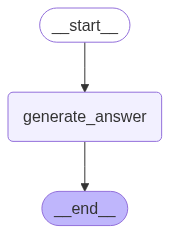

In [20]:
# GraphState 사용 예시
def generate_answer(state: GraphState) -> dict:
    # prompt 구성
    prompt = f"""
    질문: {state['question'][-1].content}
    문맥: {state['context']}
    답변해 주세요.
    """

    response = llm.invoke(prompt)

    # answer 필드에는 텍스트만 저장
    answer_text = response.content if isinstance(response, AIMessage) else response

    # messages에는 AIMessage 형태로 저장
    if isinstance(response, AIMessage):
        new_msg = response                       # 이미 AIMessage
    else:
        new_msg = AIMessage(content=response)    # 문자열이면 래핑

    return {
        "answer": answer_text,
        "messages": [new_msg]
    }

workflow = StateGraph(GraphState)

workflow.add_node("generate_answer", generate_answer)
workflow.add_edge(START, "generate_answer")

graph = workflow.compile()
graph

In [21]:
initial_state = {
    "question": [HumanMessage(content="LangChain이 뭔가요?")],
    "context": "LangChain은 LLM을 구성요소로 나누고 체인으로 구성할 수 있는 파이썬 프레임워크입니다.",
    "answer": "",
    "messages": [HumanMessage(content="LangChain이 뭔가요?")]
}

# 실행
result = graph.invoke(initial_state)

# 결과 출력
print("답변:", result["answer"])

답변: LangChain은 자연어 처리에 사용되는 파이썬 프레임워크로, 대형 언어 모델(LLM)을 여러 구성 요소로 나누어 이를 체인 형태로 연결하여 복잡한 작업을 수행할 수 있도록 도와줍니다. 이를 통해 개발자는 복잡한 자연어처리 애플리케이션을 더 쉽고 효율적으로 구축할 수 있습니다.


In [22]:
result

{'question': [HumanMessage(content='LangChain이 뭔가요?', additional_kwargs={}, response_metadata={}, id='c3ae3cbe-f0a9-4f27-b39f-c3ba56d2489b')],
 'context': 'LangChain은 LLM을 구성요소로 나누고 체인으로 구성할 수 있는 파이썬 프레임워크입니다.',
 'answer': 'LangChain은 자연어 처리에 사용되는 파이썬 프레임워크로, 대형 언어 모델(LLM)을 여러 구성 요소로 나누어 이를 체인 형태로 연결하여 복잡한 작업을 수행할 수 있도록 도와줍니다. 이를 통해 개발자는 복잡한 자연어처리 애플리케이션을 더 쉽고 효율적으로 구축할 수 있습니다.',
 'messages': [HumanMessage(content='LangChain이 뭔가요?', additional_kwargs={}, response_metadata={}, id='cff13b81-cba6-4b5c-82ae-df3ad501e331'),
  AIMessage(content='LangChain은 자연어 처리에 사용되는 파이썬 프레임워크로, 대형 언어 모델(LLM)을 여러 구성 요소로 나누어 이를 체인 형태로 연결하여 복잡한 작업을 수행할 수 있도록 도와줍니다. 이를 통해 개발자는 복잡한 자연어처리 애플리케이션을 더 쉽고 효율적으로 구축할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 60, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_de

### 대화 기록 관리
챗봇을 구축할 때 이해해야 할 중요한 개념 중 하나는 대화 기록을 관리하는 방법입니다. 관리하지 않으면 메시지 목록이 무한정 늘어나 LLM 컨텍스트 창을 초과할 수 있습니다. 따라서 전달하는 메시지의 크기를 제한하는 단계를 추가하는 것이 중요합니다.

중요한 점은 프롬프트 템플릿을 사용하기 전, 그리고 메시지 기록에서 이전 메시지를 로드한 후에 이 작업을 수행해야 한다는 것입니다.

메시지 키를 적절히 수정하는 간단한 단계를 프롬프트 앞에 추가한 다음, 해당 새 체인을 Message History class로 래핑하면 됩니다.

LangChain에는 메시지 목록을 관리하기 위한 몇 가지 기본 제공 도우미가 있습니다. 이 경우 trim_messages 도우미를 사용하여 모델로 전송하는 메시지 수를 줄여 보겠습니다. 트리머를 사용하면 보관할 토큰 수와 시스템 메시지를 항상 보관할지 여부, 부분 메시지 허용 여부 등의 매개변수를 지정할 수 있습니다.

In [23]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, trim_messages

# 메시지 트리머(trimmer) 설정
trimmer = trim_messages(
    max_tokens=65,             # 토큰 수 제한: 최대 65 토큰만 남김
    strategy="last",           # "last": 가장 최근(max_tokens 이하)의 메시지를 유지
    token_counter=llm,         # LLM을 사용해 실제 토큰 수 계산
    include_system=True,       # 시스템 메시지(SystemMessage)는 항상 포함
    allow_partial=False,       # 메시지 일부만 포함하지 않음
    start_on="human",          # “human” 메시지 이후부터 시작
)

# 테스트용 메시지 목록: 대화 흐름 예시
messages = [
    SystemMessage(content="당신은 훌륭한 도우미입니다."),
    HumanMessage(content="안녕! 나는 길동이야."),
    AIMessage(content="안녕!"),
    HumanMessage(content="나는 바닐라 아이스크림을 좋아해."),
    AIMessage(content="좋네."),
    HumanMessage(content="2 + 2 는 얼마야?"),
    AIMessage(content="4"),
    HumanMessage(content="고마워"),
    AIMessage(content="천만에!"),
    HumanMessage(content="재미있어?"),
    AIMessage(content="응!"),
]

# 트리머 호출: 메시지 리스트를 주면 max_tokens 이하로 줄여줍니다
trimmed = trimmer.invoke(messages)

# 결과를 출력하여 어떤 메시지가 유지되었는지 확인
print("Trimmed messages:")
for msg in trimmed:
    print(f"{msg.__class__.__name__}: {msg.content}")

Trimmed messages:
SystemMessage: 당신은 훌륭한 도우미입니다.
HumanMessage: 고마워
AIMessage: 천만에!
HumanMessage: 재미있어?
AIMessage: 응!


--------------
체인에서 사용하려면 메시지 입력을 프롬프트에 전달하기 전에 트리머를 실행하기만 하면 됩니다.

MessagesState는 챗봇을 위해 대화 기록만을 다루는 간단한 스키마이므로 추가 필드가 필요하면 State(TypedDict) 로 상태 스키마를 정의해야합니다.  
```
class MessagesState(TypedDict):
    messages: Annotated[list[BaseMessage], operator.add]

```

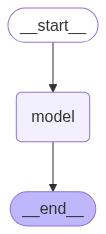

In [24]:
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage
import operator

# --- 상태 스키마 정의 ---
class State(TypedDict):
    # messages: BaseMessage 타입의 시퀀스로 이루어진 리스트
    # Annotated를 사용하여 병합 시 operator.add(덧셈 연산)로 처리되도록 지정
    # 즉, 병렬 노드에서 메시지가 동시에 추가되면 리스트에 누적됨
    messages: Annotated[Sequence[BaseMessage], operator.add]
    
    # language: 문자열로 구성된 언어 정보
    # 병합 방식이 지정되지 않았으므로, 기본적으로 마지막 값으로 덮어쓰기 됨
    language: str

# State 스키마를 기반으로 LangGraph 워크플로우 생성
workflow = StateGraph(state_schema=State)

# 상태를 입력받아 메시지를 트리밍하고, 프롬프트를 구성한 뒤, LLM 호출 결과를 반환하는 함수입니다.
def call_model(state: State):
    # 현재 메시지 리스트를 토큰 수 기준으로 잘라냅니다 (예: max_tokens=65 등)
    trimmed_messages = trimmer.invoke(state["messages"])

    # 프롬프트 템플릿에 잘린 메시지와 언어 정보를 넣어 프롬프트 생성
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )

    # 모델 호출 → 결과 메시지 반환
    response = llm.invoke(prompt)

    # LangGraph에서는 다음 상태로 넘어갈 때 딕셔너리 형태로 반환합니다.
    return {"messages": [response]}

# --- 워크플로우 구성 ---
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# 대화 상태를 저장하기 위한 메모리 객체를 사용합니다 (기본 제공 MemorySaver).
memory = MemorySaver()

# 모든 노드와 엣지를 기반으로 LangGraph 앱을 생성합니다.
app = workflow.compile(checkpointer=memory)
app

이제 모델에게 이름을 물어보면 채팅 기록의 해당 부분을 잘라냈기 때문에 모델이 이름을 알 수 없습니다.

In [25]:
config = {"configurable": {"thread_id": "abc345"}}

query = "내 이름이 뭐지?"

input_messages = messages + [HumanMessage(query)]
output = app.invoke({"messages": input_messages, "language": "한국어"}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

미안하지만, 난 네 이름을 모르겠어. 알려줄래?


# 라우터 (Router)

## 복습 (Review)

우리는 `messages`를 상태로 사용하고, **도구가 바인딩된 채팅 모델**을 사용하는 그래프를 만들었습니다.

이 그래프는 다음과 같은 동작을 할 수 있었습니다:

* 도구 호출을 반환
* 자연어 응답을 반환

## 목표 (Goals)

이 구조는 일종의 **라우터(router)** 로 볼 수 있습니다.
즉, **채팅 모델이 사용자 입력에 따라 도구를 호출하거나 직접 응답**하도록 흐름을 라우팅합니다.

이는 간단한 **에이전트(agent)** 의 예시로, LLM이 도구를 호출하거나 직접 응답하는 방식으로 **제어 흐름(control flow)** 을 결정하는 구조입니다.

![라우터 예시 이미지](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

이제 이 그래프를 확장하여 **두 가지 출력 방식 모두 처리할 수 있도록** 해보겠습니다!

이를 위해 다음 두 가지 아이디어를 사용할 수 있습니다:

1. **도구를 실제로 호출하는 노드**를 추가합니다.
2. **조건부 엣지**를 추가하여, 채팅 모델의 출력을 확인한 뒤

   * 도구 호출이 있다면 도구 노드로
   * 도구 호출이 없다면 바로 종료 노드로 이동하도록 라우팅합니다.

In [27]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4.1-nano")
llm_with_tools = llm.bind_tools([multiply])

우리는 [내장된 `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode)를 사용하며,
**초기화 시 도구 목록(list of tools)** 만 전달하면 됩니다.

또한, [내장된 `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition)를
**조건부 엣지(conditional edge)** 로 사용합니다.


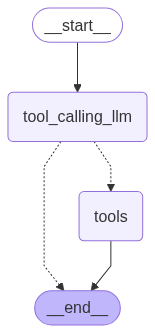

In [28]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # 만약 assistant의 마지막 메시지(결과)가 도구 호출이면 -> tools_condition은 tools 노드로 이동합니다.
    # 만약 assistant의 마지막 메시지가 도구 호출이 아니면 -> tools_condition은 END 노드로 이동합니다.
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="안녕, 2 곱하기 2는 얼마야?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

안녕, 2 곱하기 2는 얼마야?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YerdonOwKPPKT14rEAKmbcZv)
 Call ID: call_YerdonOwKPPKT14rEAKmbcZv
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4
